In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
import scipy.signal as signal
from scipy.signal import lfilter
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler




# !sudo apt-get install p7zip-full

In [2]:
!pip install Gammatone
!pip install butter

from gammatone.gtgram import gtgram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 755.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for butter: filename=butter-0.13.1-cp310-cp310-linux_x86_64.whl size=156395 sha256=27ec7f331f7c6b30d10da86974ef08448cf87c95d3df140ca2c1fd640b18d5e0
  Stored in directory: /root/.cache/pip/wheels/c8/bd/29/66b0761bf15e50dce66f96ccf3f3fd6425943beffa8861878b
Successfully built butter


MOUNT GOOGLE DRIVE

In [3]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"

In [4]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


In [5]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [6]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save.head(3)

,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
key,,,,,,,,
a24e3cbe-eda1-40b9-8f9d-57c939ef3663,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...","[-6.8540386e-12, -6.674442e-12, 4.356682e-12, ...",16000,22050,[27840],[38367],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28b68991-11d8-48dd-b0ce-ab7bb44f0383,"[1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[157440],[216972],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0b2f75d7-f116-4f35-ae4c-f2018eab2794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[155520],[214326],"[[1.651429, 1.891429], [2.022857, 2.331429], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)



['__init__.py', 'feature_extraction.py', 'framing.py', 'simple_ingestion.py', 'sono_cross_val.py', 'utils.py', '__pycache__']


In [8]:
from framing import Framing

FRAMINGS

Frame size 1024, hop_length 512, count 82957
Frame size 2048, hop_length 1024, count 41222
Hop Length: 512


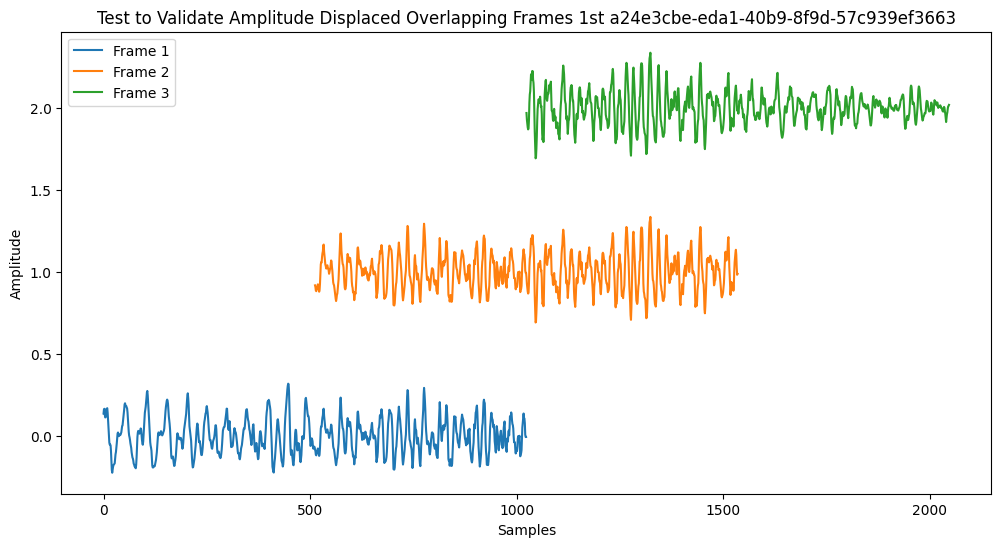

Hop Length: 512


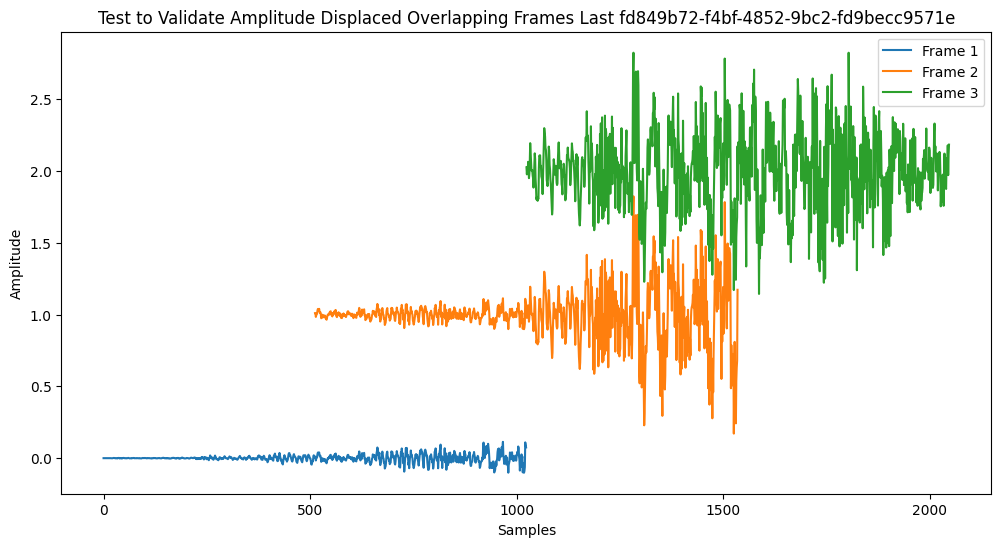

In [9]:

frame = Framing()

all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024,2048])
df_frame_from_save = all_frames_from_save[1024]
df_frame_from_save.head(3)

visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

Hop Length: 512


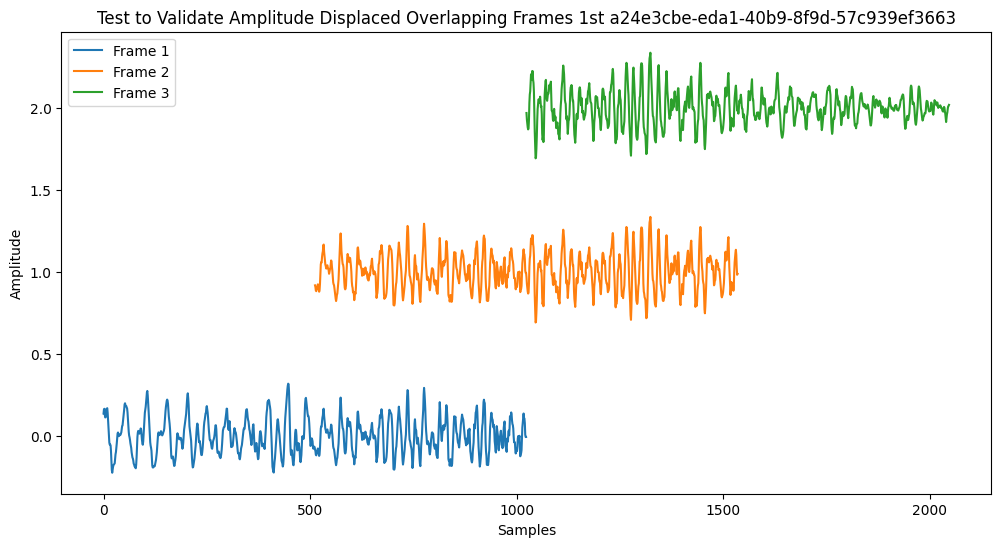

Hop Length: 512


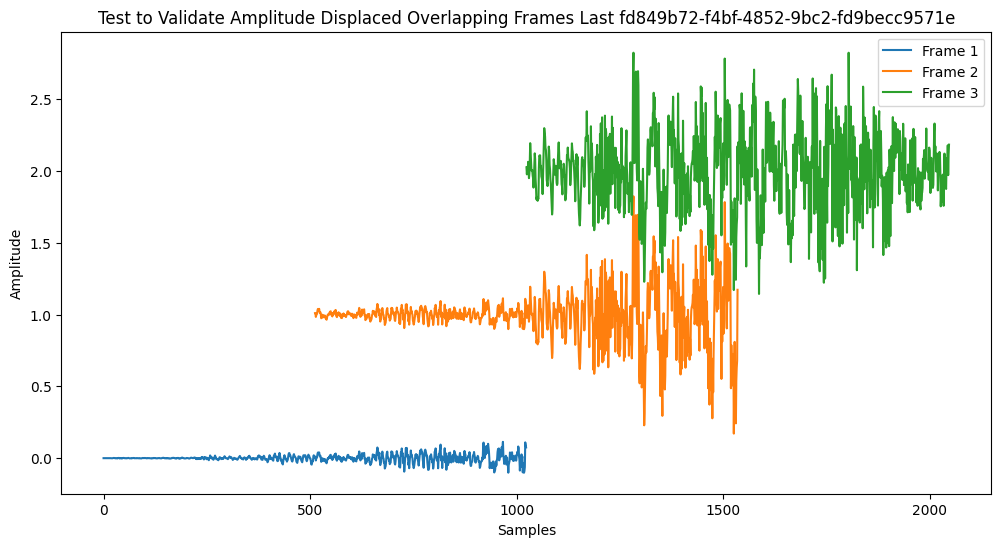

In [10]:
# Visualize overlapping frames
visual_set = {"1st": df_frame_from_save.head(1)["key"].values[0], "Last": df_frame_from_save.tail(1)["key"].values[0]}
frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)
#plt.show()

In [11]:
# Inspect the DataFrame columns to ensure the correct column names are used
print(df_frame_from_save.columns)
df_from_save["amp"]

Index(['key', 'sf', 'start', 'end', 'max_amp', 'frame_index', 'amp', 'label'], dtype='object')


key
a24e3cbe-eda1-40b9-8f9d-57c939ef3663    [-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...
28b68991-11d8-48dd-b0ce-ab7bb44f0383    [1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...
0b2f75d7-f116-4f35-ae4c-f2018eab2794    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
d2ce5b46-e4ca-4a35-938a-d18309ec8537    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
eade4e05-0fe3-4736-8a9c-35467d078113    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                              ...                        
e6448323-4be3-4fac-ba98-33aee0de0817    [-1.4024037e-12, 1.8094825e-12, -1.8148147e-12...
42d1cba8-f6a3-45f3-971b-03e212ce4142    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6147e276-9553-46cf-970c-a5c43309a5fc    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
305898a2-7331-45a4-8080-6fe0947443e9    [1.8791303e-08, -1.5504117e-08, -1.2779726e-08...
fd849b72-f4bf-4852-9bc2-fd9becc9571e    [3.5567125e-20, 6.774533e-20, 2.7358853e-21, 8...
Name: 

In [12]:
df_frame_from_save

,key,sf,start,end,max_amp,frame_index,amp,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,8.836885e-05,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,6.821569e-05,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,6.644696e-05,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0
3,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1536,2560,2.835689e-08,3,"[-1.41313e-08, 1.9094735e-08, -2.2920153e-08, ...",0
4,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,2048,3072,9.907748e-16,4,"[-1.5186867e-16, -6.784829e-17, 7.3962843e-16,...",0
...,...,...,...,...,...,...,...,...
82952,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,69632,70656,3.533897e-05,136,"[1.4073834e-07, -1.5136347e-07, 1.5978313e-07,...",0
82953,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70144,71168,2.780168e-12,137,"[1.7115064e-12, 2.0663297e-12, 1.2099997e-12, ...",0
82954,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70656,71680,1.853762e-06,138,"[-4.7537818e-18, 3.464349e-18, -1.100551e-18, ...",0
82955,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,71168,72192,1.853762e-06,139,"[5.8562245e-14, -1.3361285e-14, 4.9188924e-14,...",0


## **FEATURE EXTRACTION **

## **Gammatone and STFT**

# **FeatureExtractionSpectrogram**

In [13]:
class FeatureExtractionSpectrogram:
    def stft(self, df):
        """Read audio data and apply short_time_fourier_transform

        Parameters:
        df (pd.DataFrame): Pandas DataFrame

        Return df
        """
        df_from_save["amp"]
        ft = []
        ft_shape = []
        for index, row in df.iterrows():
            n_fft = min(2048, len(row["amp"]))
            amp_filtered = self.apply_gammatone_filter(row["amp"])
            stft = librosa.amplitude_to_db(np.abs(librosa.stft(amp_filtered, n_fft=n_fft)), ref=np.max)
            ft.append(stft)
            ft_shape.append(stft.shape)

        df["stft"] = ft
        df["stft_shape"] = ft_shape

        return df

    def stft_optimized(self, row):
        """Read audio data and apply short_time_fourier_transform in shorter period of time

        Parameters:
        row (pd.DataFrame row): Pandas DataFrame row

        Return row
        """
        amp_filtered = self.apply_gammatone_filter(row["amp"])
        stft = librosa.amplitude_to_db(np.abs(librosa.stft(amp_filtered, n_fft=self.n_fft, hop_length=self.hop_length, win_length=self.win_length)), ref=np.max)
        return stft

    def set_sftt_params(self, n_fft, hop_length, win_length):
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.win_length = win_length
        print(f'using n_fft:{self.n_fft}, hop length:{self.hop_length}, win_length:{self.win_length}')


In [14]:
df_from_save["amp"]
#df_from_save["label"]


key
a24e3cbe-eda1-40b9-8f9d-57c939ef3663    [-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...
28b68991-11d8-48dd-b0ce-ab7bb44f0383    [1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...
0b2f75d7-f116-4f35-ae4c-f2018eab2794    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
d2ce5b46-e4ca-4a35-938a-d18309ec8537    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
eade4e05-0fe3-4736-8a9c-35467d078113    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                              ...                        
e6448323-4be3-4fac-ba98-33aee0de0817    [-1.4024037e-12, 1.8094825e-12, -1.8148147e-12...
42d1cba8-f6a3-45f3-971b-03e212ce4142    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6147e276-9553-46cf-970c-a5c43309a5fc    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
305898a2-7331-45a4-8080-6fe0947443e9    [1.8791303e-08, -1.5504117e-08, -1.2779726e-08...
fd849b72-f4bf-4852-9bc2-fd9becc9571e    [3.5567125e-20, 6.774533e-20, 2.7358853e-21, 8...
Name: 

In [15]:
# prompt: generate the path to read audio file df_from_save["amp"] for gammatone filter

def get_audio_paths(df_from_save):
  """Generates the path to read audio file for gammatone filter.

  Args:
      df_from_save: Pandas DataFrame containing audio data.

  Returns:
      list: List of paths to read audio files.
  """

  audio_paths = df_from_save["amp"]
  for index, row in df_from_save.iterrows():
    audio_path = f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"
    #audio_paths.append(audio_path)

  return audio_paths

audio_paths = get_audio_paths(df_from_save)
x = audio_paths
print(x)


key
a24e3cbe-eda1-40b9-8f9d-57c939ef3663    [-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...
28b68991-11d8-48dd-b0ce-ab7bb44f0383    [1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...
0b2f75d7-f116-4f35-ae4c-f2018eab2794    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
d2ce5b46-e4ca-4a35-938a-d18309ec8537    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
eade4e05-0fe3-4736-8a9c-35467d078113    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                              ...                        
e6448323-4be3-4fac-ba98-33aee0de0817    [-1.4024037e-12, 1.8094825e-12, -1.8148147e-12...
42d1cba8-f6a3-45f3-971b-03e212ce4142    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6147e276-9553-46cf-970c-a5c43309a5fc    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
305898a2-7331-45a4-8080-6fe0947443e9    [1.8791303e-08, -1.5504117e-08, -1.2779726e-08...
fd849b72-f4bf-4852-9bc2-fd9becc9571e    [3.5567125e-20, 6.774533e-20, 2.7358853e-21, 8...
Name: 

In [16]:
# prompt: df_frame_from_save.head(1)['amp'].values[0].shape divide this into subframes of 128

subframes_per_frame = 8
subframe_size = 128

# Extract the audio data from the first row
#audio_data = df_frame_from_save.head(1)['amp'].values[0]
#audio_data = df_from_save['amp'].values[0]
#audio_data = df_frame_from_save.head(1)['amp'].values[0]
audio_data = df_frame_from_save.head(1024)['amp'].values[0]




# Divide the audio data into subframes
num_subframes = len(audio_data) // subframe_size
subframes = np.zeros((num_subframes, subframe_size))
for i in range(num_subframes):
    subframes[i] = audio_data[i * subframe_size:(i + 1) * subframe_size]

# Print the shape of the subframes
print(subframes.shape)

(8, 128)


In [17]:
# prompt: read through the code and find the path to wav

audio_path = f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"


In [18]:
print(audio_data.shape)
audio_data

(1024,)


array([-1.3439313e-12, -8.8915611e-12,  7.9569702e-12, ...,
        3.0517589e-05,  3.0517565e-05,  3.0517593e-05], dtype=float32)

In [19]:
df_frame_from_save

,key,sf,start,end,max_amp,frame_index,amp,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,8.836885e-05,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,6.821569e-05,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,6.644696e-05,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0
3,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1536,2560,2.835689e-08,3,"[-1.41313e-08, 1.9094735e-08, -2.2920153e-08, ...",0
4,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,2048,3072,9.907748e-16,4,"[-1.5186867e-16, -6.784829e-17, 7.3962843e-16,...",0
...,...,...,...,...,...,...,...,...
82952,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,69632,70656,3.533897e-05,136,"[1.4073834e-07, -1.5136347e-07, 1.5978313e-07,...",0
82953,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70144,71168,2.780168e-12,137,"[1.7115064e-12, 2.0663297e-12, 1.2099997e-12, ...",0
82954,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70656,71680,1.853762e-06,138,"[-4.7537818e-18, 3.464349e-18, -1.100551e-18, ...",0
82955,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,71168,72192,1.853762e-06,139,"[5.8562245e-14, -1.3361285e-14, 4.9188924e-14,...",0


WORKABLE CODE BELOW

In [20]:
import numpy as np
import librosa
import gammatone
from gammatone import filters
from gammatone import fftweight
import matplotlib.pyplot as plt
import pandas as pd



audio_path = "/content/drive/My Drive/23-24_CE903-SU_team06/dataset/audio_data_300_before_framing_16Khz.feather"  # Replace with your actual path
df = pd.read_feather(audio_path) # Read the feather file into a DataFrame **BEFORE** trying to extract audio data


In [21]:
print(audio_data.shape)
audio_data

(1024,)


array([-1.3439313e-12, -8.8915611e-12,  7.9569702e-12, ...,
        3.0517589e-05,  3.0517565e-05,  3.0517593e-05], dtype=float32)

# **testing**

In [22]:
import numpy as np
import librosa
from gammatone import filters, fftweight
from tqdm import tqdm

# Parameters
frame_size = 1024
num_channels = 64
subframe_size = 128
window_time = 0.004
hop_time = 0.004
sample_rate = 16000

def process_audio(audio_data):
    # Ensure audio is 1D
    audio_data = audio_data.flatten()

    # Compute STFT
    stft = librosa.stft(audio_data, n_fft=frame_size,
                        hop_length=int(sample_rate * hop_time),
                        win_length=int(sample_rate * window_time),
                        window='hann')

    # Convert to amplitude spectrogram
    amp_spec = np.abs(stft)

    # Create Gammatone filterbank
    center_freqs = filters.erb_space(20, sample_rate/2, num_channels)
    fbank = filters.make_erb_filters(sample_rate, center_freqs)

    # Apply Gammatone filterbank to the amplitude spectrogram
    gammatone_features = fftweight.fft_gtgram(audio_data, sample_rate, window_time, hop_time, num_channels, frame_size)

    # Reshape the features into subframes
    num_frames = gammatone_features.shape[1]
    hop_length = int(sample_rate * hop_time)
    num_subframes = num_frames // (subframe_size // hop_length)
    gammatone_subframes = gammatone_features[:, :num_subframes * (subframe_size // hop_length)]

    try:
        gammatone_subframes = gammatone_subframes.reshape(num_channels, num_subframes, subframe_size)
    except ValueError:
        # Handle case where reshape fails
        return None

    return gammatone_subframes

# List to store all processed features
all_features = []

# Loop through all 82957 recordings
for i in tqdm(range(len(df_frame_from_save['amp']))):
    audio = df_frame_from_save['amp'].iloc[i]
    features = process_audio(audio_data)
    if features is not None:
        all_features.append(features)

# Convert list to numpy array
all_features = np.array(all_features)

print(f"Processed features shape: {all_features.shape}")


100%|██████████| 82957/82957 [04:00<00:00, 344.27it/s]

Processed features shape: (0,)


100%|██████████| 82957/82957 [01:37<00:00, 850.01it/s]


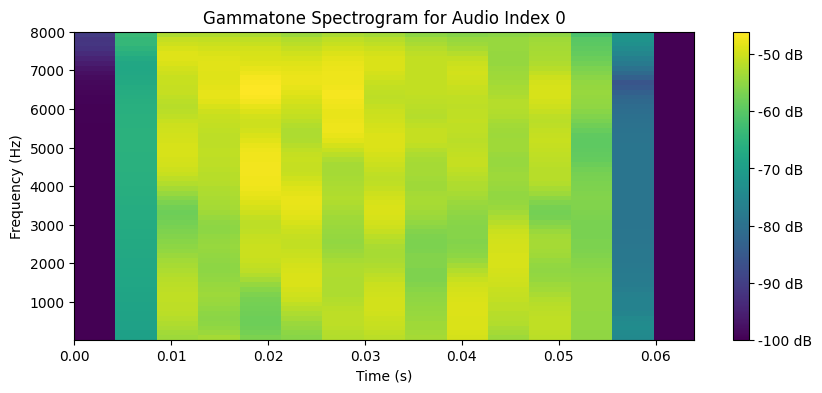

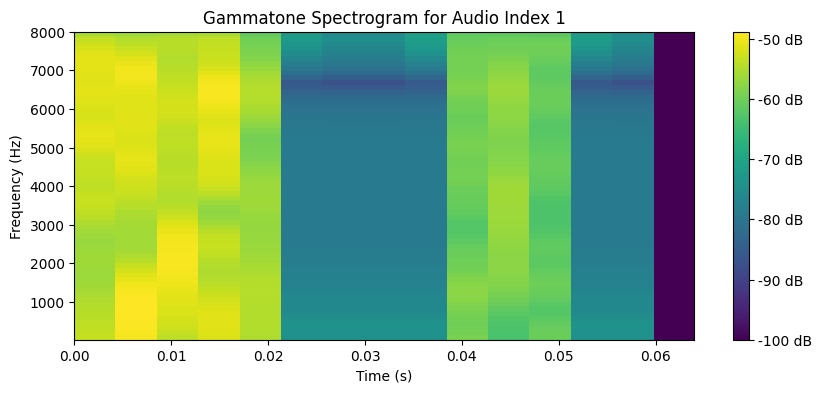

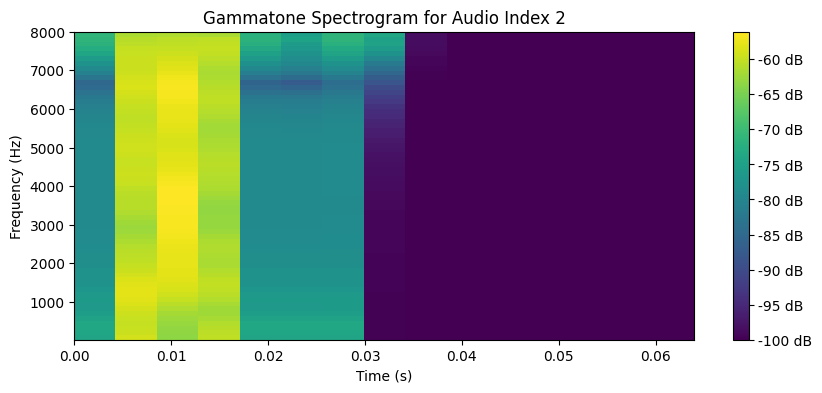

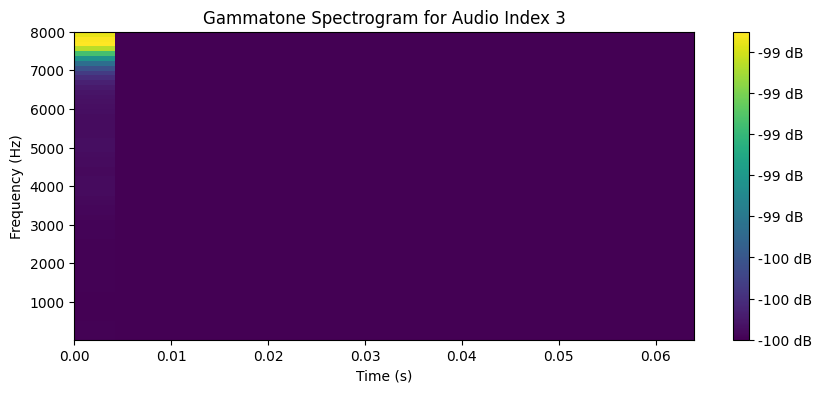

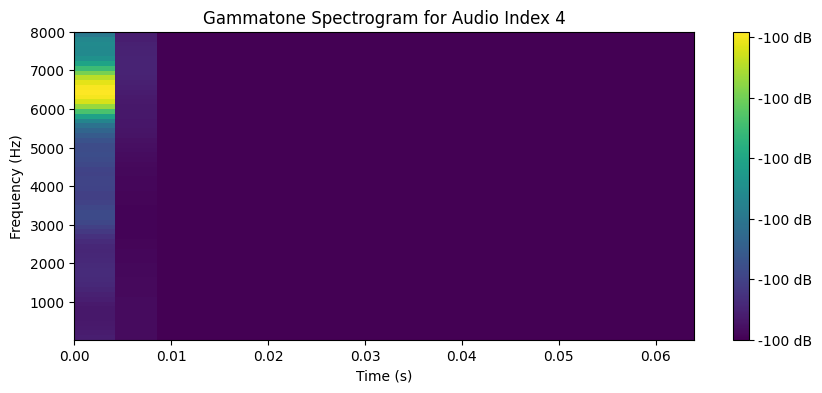

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
from gammatone import filters, fftweight

# Parameters
frame_size = 1024
num_channels = 64
subframe_size = 128
window_time = 0.004
hop_time = 0.004
sample_rate = 16000

# Function to process audio data
def process_audio(audio_data):
    audio_data = audio_data.flatten()
    gammatone_features = fftweight.fft_gtgram(audio_data, sample_rate, window_time, hop_time, num_channels, frame_size)
    return gammatone_features

# List to store features
all_features = []

# Loop through all recordings
for idx in tqdm(range(len(df_frame_from_save['amp']))):
    audio_data = df_frame_from_save['amp'].iloc[idx]
    features = process_audio(audio_data)
    all_features.append(features)

# Convert to numpy array
all_features = np.array(all_features)

# Visualize a subset of recordings
for audio_index in range(5):  # Adjust the range to visualize more samples
    audio_data = df_frame_from_save['amp'].iloc[audio_index]
    gammatone_features = process_audio(audio_data)

    # Plot Gammatone spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(10 * np.log10(gammatone_features + 1e-10), aspect='auto', origin='lower',
               extent=[0, len(audio_data) / sample_rate, 20, sample_rate / 2])
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Gammatone Spectrogram for Audio Index {audio_index}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()


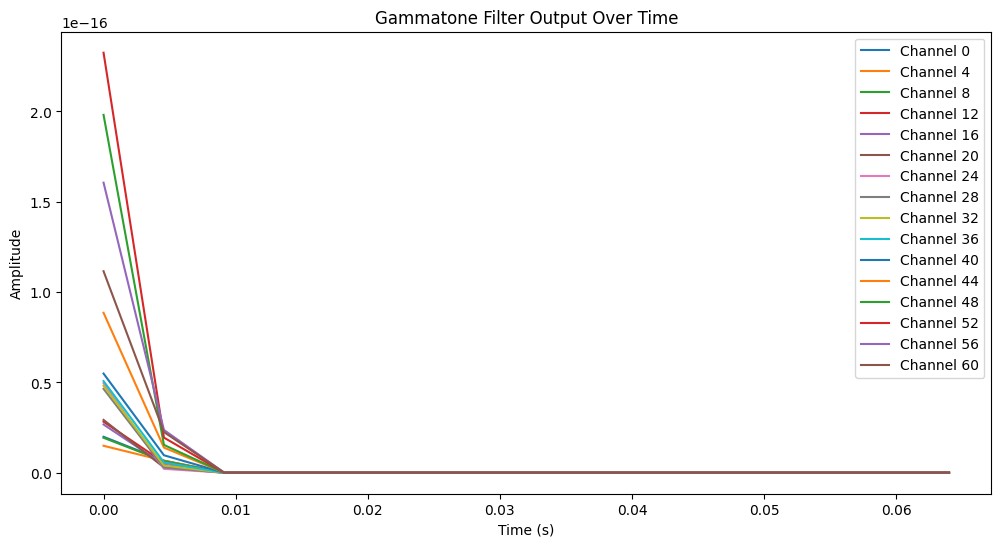

In [24]:
# Plot Gammatone features over time
plt.figure(figsize=(12, 6))
time_axis = np.linspace(0, len(audio_data) / sample_rate, gammatone_features.shape[1])
for i in range(0, num_channels, 4):
    plt.plot(time_axis, gammatone_features[i, :], label=f'Channel {i}')
plt.title('Gammatone Filter Output Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

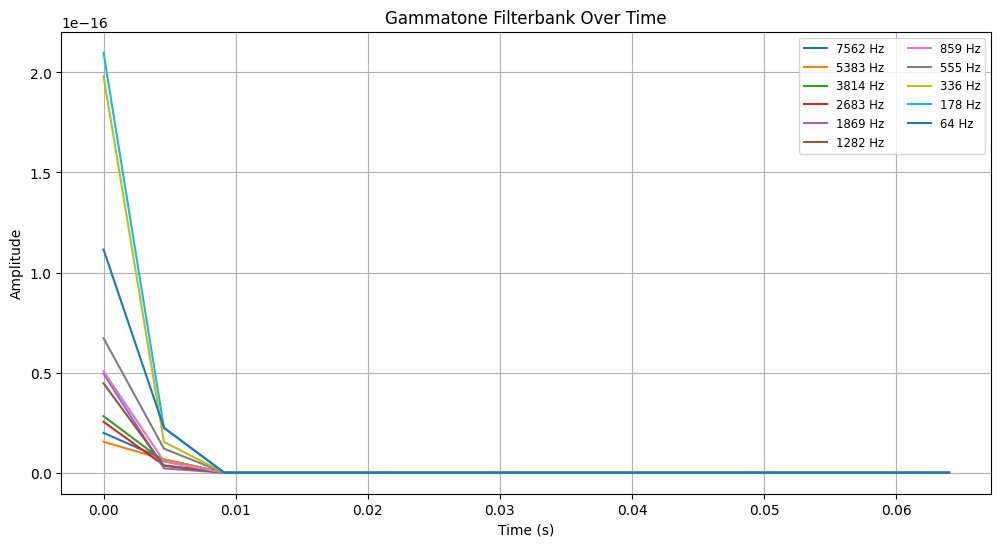

In [25]:
# Plot Gammatone filterbank over time
plt.figure(figsize=(12, 6))
time_axis = np.linspace(0, len(audio_data) / sample_rate, gammatone_features.shape[1])
center_freqs = filters.erb_space(20, sample_rate / 2, num_channels)

for i in range(0, num_channels, 6):  # Adjusting step for clarity
    plt.plot(time_axis, gammatone_features[i, :], label=f'{int(center_freqs[i])} Hz')

plt.title('Gammatone Filterbank Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.show()

## **updated**

100%|██████████| 82957/82957 [01:41<00:00, 817.04it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 13, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 6, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 4, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 2, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 128)               2

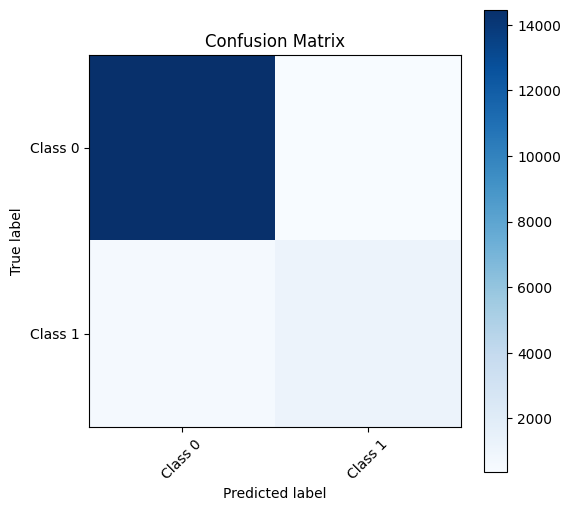

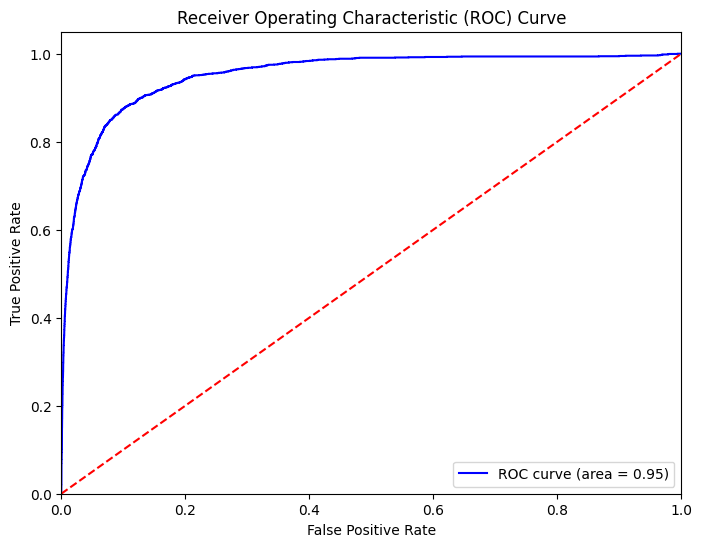

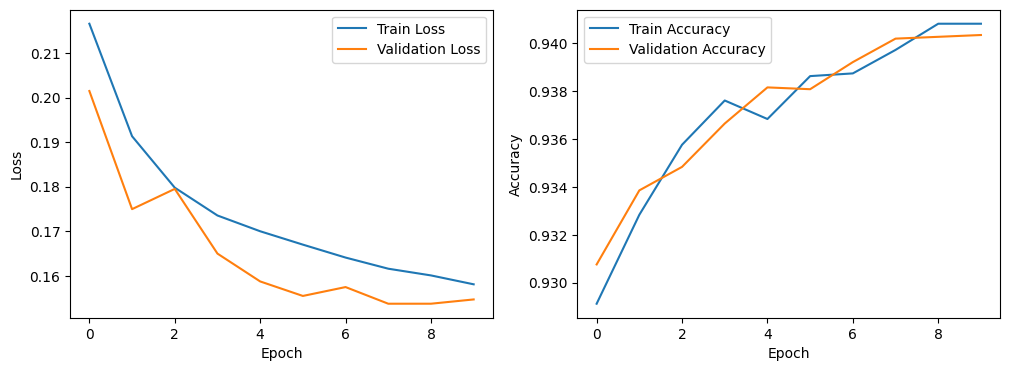

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
from tensorflow.keras import layers, models
from tqdm import tqdm
from gammatone import fftweight

# Parameters
frame_size = 1024
num_channels = 64
subframe_size = 128
window_time = 0.004
hop_time = 0.004
sample_rate = 16000

# Function to process audio data
def process_audio(audio_data):
    audio_data = audio_data.flatten()
    gammatone_features = fftweight.fft_gtgram(audio_data, sample_rate, window_time, hop_time, num_channels, frame_size)
    return gammatone_features

# List to store features and labels
all_features = []
all_labels = []

# Loop through all recordings
for idx in tqdm(range(len(df_frame_from_save['amp']))):
    audio_data = df_frame_from_save['amp'].iloc[idx]
    label = df_frame_from_save['label'].iloc[idx]  # Adjust 'label' to your column name
    features = process_audio(audio_data)
    if features is not None:
        all_features.append(features)
        all_labels.append(label)

# Convert to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Reshape features for CNN
all_features = all_features.reshape(all_features.shape[0], num_channels, -1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)

# Define CNN model
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
                  metrics=['accuracy'])
    return model

# Build and train the model
input_shape = (num_channels, X_train.shape[2], 1)
model = build_model(input_shape)
model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
auc = roc_auc_score(y_test, y_pred_probs)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp) * 100

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Print metrics
print(f"AUC: {auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Specificity: {specificity:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
from tensorflow.keras import layers, models
from tqdm import tqdm
from gammatone import fftweight

# Parameters
frame_size = 1024
num_channels = 64
subframe_size = 128
window_time = 0.004
hop_time = 0.004
sample_rate = 16000

# Function to process audio data
def process_audio(audio_data):
    audio_data = audio_data.flatten()
    gammatone_features = fftweight.fft_gtgram(audio_data, sample_rate, window_time, hop_time, num_channels, frame_size)
    return gammatone_features

# List to store features and labels
all_features = []
all_labels = []

# Loop through all recordings
for idx in tqdm(range(len(df_frame_from_save['amp']))):
    audio_data = df_frame_from_save['amp'].iloc[idx]
    label = df_frame_from_save['label'].iloc[idx]  # Adjust 'label' to your column name
    features = process_audio(audio_data)
    if features is not None:
        all_features.append(features)
        all_labels.append(label)

# Convert to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Reshape features for CNN
all_features = all_features.reshape(all_features.shape[0], num_channels, -1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)

# Define CNN model
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
                  metrics=['accuracy'])
    return model

# Build and train the model
input_shape = (num_channels, X_train.shape[2], 1)
model = build_model(input_shape)
model.summary()

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
auc = roc_auc_score(y_test, y_pred_probs)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp) * 100

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Print metrics
print(f"AUC: {auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Specificity: {specificity:.2f}%")

# Plot confusion matrix with annotations
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.viridis)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])

# Add values inside the squares
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
